In [1]:
import numpy as np
from scipy.stats import gmean
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def check_average_assumption(ground_truth : np.ndarray, single_site_effects : np.ndarray, unique_sequences : np.ndarray, sequence_effects : np.ndarray, frequencies : np.ndarray) -> None:
    #compute the true background effect
    true_background = single_site_effects/ground_truth

    # compute the average background effect
    average_background = np.zeros((ground_truth.shape[0], ground_truth.shape[1]))
    for state in range(ground_truth.shape[0]):
        for position in range(ground_truth.shape[1]):
            state_indices = np.where(unique_sequences[:, position] == state)[0]
            print("state_indices: ", state_indices)
            default_indices = np.where(unique_sequences[:, position] == 0)[0]
            print("default_indices: ", default_indices)
            average_background[state, position] = (gmean(sequence_effects[state_indices], weights=frequencies[state_indices])/ground_truth[state, position])#/(gmean(sequence_effects[default_indices], weights=frequencies[default_indices])/ground_truth[0, position])

    # check if the true background effect is equal to the average background effect
    print("true background effect: \n", true_background)
    print("average background effect: \n", average_background)
    print("true background effect is equal to average background effect: ", np.allclose(true_background, average_background))

    return true_background, average_background

In [3]:
ground_truth = np.array([[1,1,1], [1, 2, 3], [4, 5, 6], [7, 8, 9]])
single_site_effects = np.array([[1, 1, 1], [1, 1.8, 3], [3.5, 3.9, 5.2], [6.1, 6.9, 7.6]])
unique_sequences = np.array([[0, 3, 0], [0, 1, 2], [1, 2, 0], [2, 0, 1], [1, 3, 0], [1, 0, 3], [0, 2, 1], [3, 1, 1]])
sequence_effects = np.array([1, 1.8, 3, 3.5, 3.9, 5.2, 6.1, 6.9, 7.6])
frequencies = np.array([0.1, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1])

check_average_assumption(ground_truth, single_site_effects, unique_sequences, sequence_effects, frequencies)

state_indices:  [0 1 6]
default_indices:  [0 1 6]
state_indices:  [3 5]
default_indices:  [3 5]
state_indices:  [0 2 4]
default_indices:  [0 2 4]
state_indices:  [2 4 5]
default_indices:  [0 1 6]
state_indices:  [1 7]
default_indices:  [3 5]
state_indices:  [3 6 7]
default_indices:  [0 2 4]
state_indices:  [3]
default_indices:  [0 1 6]
state_indices:  [2 6]
default_indices:  [3 5]
state_indices:  [1]
default_indices:  [0 2 4]
state_indices:  [7]
default_indices:  [0 1 6]
state_indices:  [0 4]
default_indices:  [3 5]
state_indices:  [5]
default_indices:  [0 2 4]
true background effect: 
 [[1.         1.         1.        ]
 [1.         0.9        1.        ]
 [0.875      0.78       0.86666667]
 [0.87142857 0.8625     0.84444444]]
average background effect: 
 [[2.10847624 4.2661458  2.59903793]
 [3.92476315 1.40853628 1.76046638]
 [0.875      0.85556999 0.3       ]
 [0.98571429 0.30970847 0.57777778]]
true background effect is equal to average background effect:  False


(array([[1.        , 1.        , 1.        ],
        [1.        , 0.9       , 1.        ],
        [0.875     , 0.78      , 0.86666667],
        [0.87142857, 0.8625    , 0.84444444]]),
 array([[2.10847624, 4.2661458 , 2.59903793],
        [3.92476315, 1.40853628, 1.76046638],
        [0.875     , 0.85556999, 0.3       ],
        [0.98571429, 0.30970847, 0.57777778]]))

In [4]:
def get_backgrounds(name : str, concentrations : list) -> tuple:

    background_diffs_r1 = []
    background_diffs_r2 = []

    for target1 in concentrations:
        for target2 in concentrations:
            path  = f"/datadisk/MIME/{name}/target1_{target1}_target2_{target2}/"

            # load round 1 avg and true backgrounds
            avg_background_r1 = np.loadtxt(path + 'round_1/assumptions/average_background.csv', delimiter=',')
            true_background_r1 = np.loadtxt(path + 'round_1/assumptions/true_background.csv', delimiter=',')
            # remove first row in both
            avg_background_r1 = avg_background_r1[1:]
            true_background_r1 = true_background_r1[1:]

            # log transform
            avg_background_r1 = np.log(avg_background_r1)
            true_background_r1 = np.log(true_background_r1)

            # flatten
            avg_background_r1 = avg_background_r1.flatten()
            true_background_r1 = true_background_r1.flatten()

            # add absolute difference to list
            background_diffs_r1.append(np.abs(avg_background_r1 - true_background_r1))

            # load round 2 avg and true backgrounds
            avg_background_r2 = np.loadtxt(path + 'round_2/assumptions/average_background.csv', delimiter=',')
            true_background_r2 = np.loadtxt(path + 'round_2/assumptions/true_background.csv', delimiter=',')

            # remove first row in both
            avg_background_r2 = avg_background_r2[1:]
            true_background_r2 = true_background_r2[1:]

            # log transform
            avg_background_r2 = np.log(avg_background_r2)
            true_background_r2 = np.log(true_background_r2)

            # flatten
            avg_background_r2 = avg_background_r2.flatten()
            true_background_r2 = true_background_r2.flatten()

            # add absolute difference to list
            background_diffs_r2.append(np.abs(avg_background_r2 - true_background_r2))

    # flatten lists
    background_diffs_r1 = np.array(background_diffs_r1).flatten()

    background_diffs_r2 = np.array(background_diffs_r2).flatten()

    return background_diffs_r1, background_diffs_r2

In [5]:
concentrations = [.1, 1, 10]

det_r1, det_r2 = get_backgrounds('deterministic_L_5_q_4_asstest', concentrations)

random_r1, random_r2 = get_backgrounds('deterministic_L_5_q_4_asstest_random', concentrations)

pruning_r1, pruning_r2 = get_backgrounds('deterministic_L_5_q_4_asstest_pruning', concentrations)

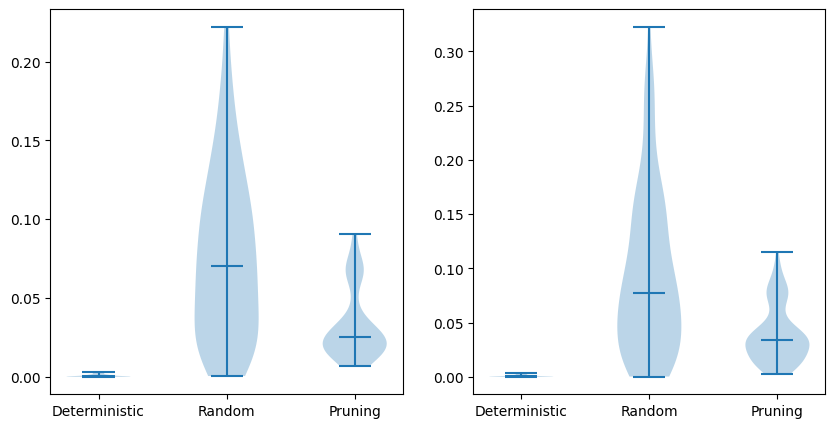

In [6]:
# violin plot comparing deterministic, random, and pruning
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.violinplot([det_r1, random_r1, pruning_r1], showmedians=True)
plt.xticks([1, 2, 3], ['Deterministic', 'Random', 'Pruning'])

plt.subplot(1, 2, 2)
plt.violinplot([det_r2, random_r2, pruning_r2], showmedians=True)
plt.xticks([1, 2, 3], ['Deterministic', 'Random', 'Pruning'])

plt.show()

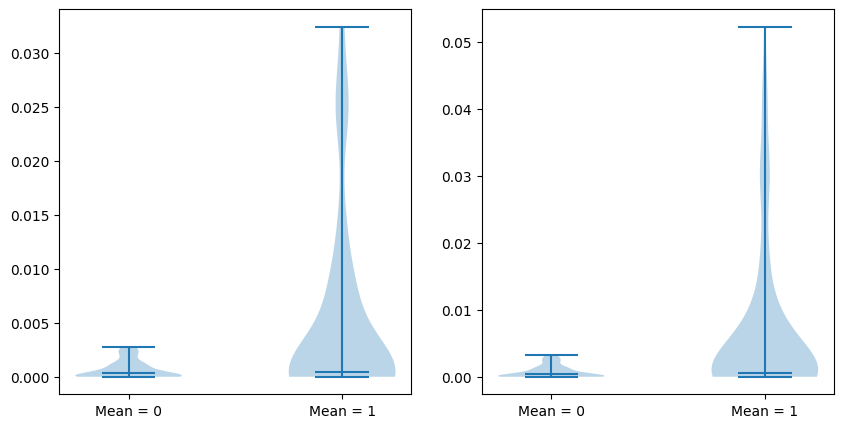

In [7]:
mean1_r1, mean1_r2 = get_backgrounds('deterministic_L_5_q_4_asstest_mean1', concentrations)

# violin plot comparing deterministic and mean1
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.violinplot([det_r1, mean1_r1], showmedians=True)
plt.xticks([1, 2], ['Mean = 0', 'Mean = 1'])

plt.subplot(1, 2, 2)
plt.violinplot([det_r2, mean1_r2], showmedians=True)
plt.xticks([1, 2], ['Mean = 0', 'Mean = 1'])

plt.show()

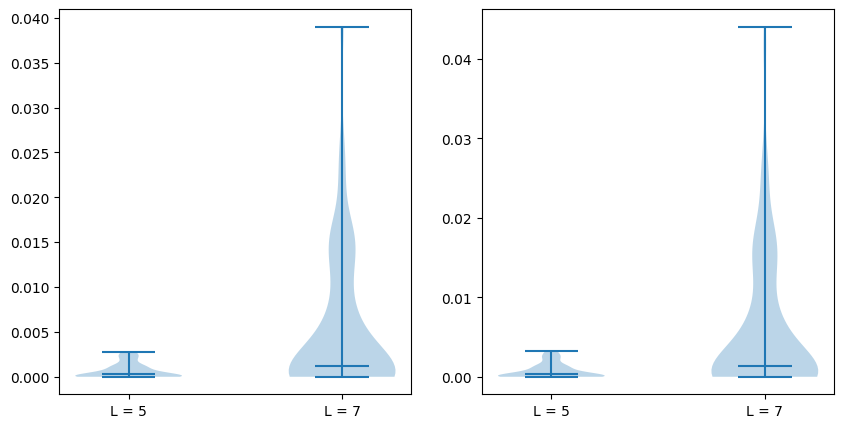

In [8]:
l7_r1, l7_r2 = get_backgrounds('deterministic_L_5_q_4_asstest_L7', concentrations)

# violin plot comparing deterministic and L7
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.violinplot([det_r1, l7_r1], showmedians=True)
plt.xticks([1, 2], ['L = 5', 'L = 7'])

plt.subplot(1, 2, 2)
plt.violinplot([det_r2, l7_r2], showmedians=True)
plt.xticks([1, 2], ['L = 5', 'L = 7'])

plt.show()

In [9]:
def check_independence_assumption(ground_truth : np.ndarray, single_site_frequencies: np.array, sequence_effects : np.ndarray, frequencies : np.ndarray) -> tuple:
    
    # get number_states and sequence length
    number_states, sequence_length = ground_truth.shape

    # compute the geometric mean of the sequence effects
    gmean_sequence_effects = gmean(sequence_effects, weights=frequencies)

    # compute the products of the geometric means of the single site effects (columns are positions, rows are states)
    gmean_single_site_effects = np.prod(gmean(ground_truth, axis=1, weights=single_site_frequencies), axis=0)

    # check if the geometric mean of the sequence effects is equal to the product of the geometric means of the single site effects
    print("gmean sequence effects: ", np.round(gmean_sequence_effects, 5))
    print("product of gmean single site effects: ", np.round(gmean_single_site_effects, 5))
    print("gmean sequence effects is equal to product of gmean single site effects: ", np.isclose(gmean_sequence_effects, gmean_single_site_effects))

    return gmean_sequence_effects, gmean_single_site_effects

In [10]:
number_states = 4
sequence_length = 5
p_effect = 0.1
p_state_change = 1/4

In [11]:
def generate_ground_truth(number_states : int, sequence_length : int, p_effect : float, mean : float) -> np.ndarray:
    # default state has value 1
    default_state = np.ones(sequence_length)
    # mutant states are drawn from a log-normal distribution
    mutant_states = np.round(np.random.lognormal(mean=mean, sigma=1, size=(number_states-1, sequence_length)),2)
    # set mutant states to 1 with probability 1 - p_effect
    mutant_states = np.where(np.random.rand(*mutant_states.shape) < 1-p_effect, 1, mutant_states)

    return np.row_stack((default_state, mutant_states))

In [12]:
def generate_sequences(ground_truth : np.ndarray, p_state_change : float, random : bool = False, pruning : bool = False) -> np.ndarray:

    # get number_states and sequence length
    number_states, sequence_length = ground_truth.shape

    # create every possible sequence
    sequences = np.array(np.meshgrid(*[np.arange(number_states)]*sequence_length)).T.reshape(-1, sequence_length)

    if not random: 
        # calculate the probability of each sequence as p_state_change**number of state changes * (1-p_state_change)**(sequence_length - number of state changes)
        state_changes = np.sum(sequences != np.zeros(sequence_length), axis=1)
        frequencies = (p_state_change/(number_states-1))**state_changes * (1-p_state_change)**(sequence_length - state_changes)

    if random:
        # generate a random frequency for each sequence
        frequencies = np.random.rand(sequences.shape[0])
        # normalize frequencies
        frequencies = frequencies / np.sum(frequencies)

    if pruning:
        # set frequency < 0.00001 to 0
        frequencies = np.where(frequencies < 0.001, 0, frequencies)
        #normalize frequencies
        frequencies = frequencies / np.sum(frequencies)


    # compute effect of each unique sequence
    # effect of a sequence is the product of the effects of the states per position
    sequence_effects = np.array([np.prod([ground_truth[int(sequences[i,j]), j] for j in range(sequence_length)]) for i in range(sequences.shape[0])])

    # print("sequences: ", sequences)
    print("frequencies: ", frequencies)
    print("sequence_effects: ", sequence_effects)

    return sequences, frequencies, sequence_effects

In [13]:
def compute_single_site_frequencies(sequences : np.ndarray, frequencies : np.ndarray, number_states : int, sequence_length : int) -> np.ndarray:
    # create a matrix of frequencies of each state at each position
    single_site_frequencies = np.zeros((number_states, sequence_length))
    for i in range(number_states):
        for j in range(sequence_length):
            # get the row indices of the unique sequences that have state i at position j
            row_indices = np.where(sequences[:,j] == i)[0]
            # sum the counts of these sequences
            single_site_frequencies[i,j] = np.sum(frequencies[row_indices])

    return single_site_frequencies

In [14]:
def assumption_test(number_states : int, sequence_length : int, p_effect : float, p_state_change : float, random : bool = False, pruning : bool = False, mean: float = 0) -> None:
    # generate ground truth
    ground_truth = generate_ground_truth(number_states, sequence_length, p_effect, mean)

    # generate sequences
    sequences, frequencies, sequence_effects = generate_sequences(ground_truth, p_state_change, random, pruning)

    # compute single site frequencies
    single_site_frequencies = compute_single_site_frequencies(sequences, frequencies, number_states, sequence_length)

    # check independence assumption
    gmean_sequence_effects, gmean_single_site_effects = check_independence_assumption(ground_truth, single_site_frequencies, sequence_effects, frequencies)

    return np.log(gmean_sequence_effects), np.log(gmean_single_site_effects)

In [15]:
# do the assumption test for different scenarios with n=100 simulations
n = 1000
number_states = 4
sequence_length = 5
p_effect = 0.7
p_state_change = 1/4

det = []
random = []
pruning = []
random_pruning = []

for i in range(n):

    gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, sequence_length, p_effect, p_state_change)
    det.append((gmean_sequence_effects, gmean_single_site_effects))
    
    gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, sequence_length, p_effect, p_state_change, random=True)
    random.append((gmean_sequence_effects, gmean_single_site_effects))
    
    gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, sequence_length, p_effect, p_state_change, pruning=True)
    pruning.append((gmean_sequence_effects, gmean_single_site_effects))

frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [1.       1.       1.72     ... 2.1609   3.716748 2.1609  ]
gmean sequence effects:  1.23259
product of gmean single site effects:  1.65182
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [1.53103643e-03 1.37877470e-03 1.40134003e-03 ... 2.21729669e-04
 1.04138751e-06 1.53580368e-03]
sequence_effects:  [1.        0.3       0.22      ... 0.064356  0.0471944 0.2123748]
gmean sequence effects:  0.34406
product of gmean single site effects:  0.42507
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [0.26470588 0.02941176 0.02941176 ... 0.         0.         0.        ]
sequence_effects:  [1.       1.       0.23     ... 5.5878   1.285194 4.246728]
gmean sequence effects:  0.9446
product of gmean single site effects:  0.84696
gmean sequence effects is equal to product of gmea

In [16]:
#get differences between gmean_sequence_effects and gmean_single_site_effects
det_diff = [np.abs(det[i][0] - det[i][1]) for i in range(n)]
random_diff = [np.abs(random[i][0] - random[i][1]) for i in range(n)]
pruning_diff = [np.abs(pruning[i][0] - pruning[i][1]) for i in range(n)]

print("deterministic: ", det_diff)
print("random: ", random_diff)
print("pruning: ", pruning_diff)

deterministic:  [0.29276118316921135, 0.23449498486106776, 0.7058544665156711, 0.05881978224892324, 0.585589317552291, 1.121748936159988, 0.05037138967204556, 0.3626296019631653, 0.49428865602258465, 0.17244414235948796, 0.5583812177587137, 0.41827028427189145, 0.6304078490867853, 0.2960743621382648, 0.05445322707105117, 0.06641049234350196, 0.13105607083901835, 0.34488955233982227, 0.6127740303612529, 1.0027265958563092, 0.6453168711149667, 0.6606580491997911, 0.16954780652357637, 0.08503359586018468, 0.6712586124610205, 0.8270003316683835, 0.09398675836079413, 0.014276680474903578, 0.03757724889094598, 0.0015070498500428223, 0.21540650866706967, 0.5803755604580254, 0.698570572658908, 0.15204642264354068, 0.8617156673664711, 0.17026177405080734, 0.3227027128654577, 0.29024808340170216, 0.09185830030644361, 0.27706497881967174, 0.6801606304762426, 1.0671118395849741, 0.9542509871231815, 0.4535807884802784, 0.1855618162015192, 0.39011992026678827, 0.2076899161521273, 0.06758379240452114

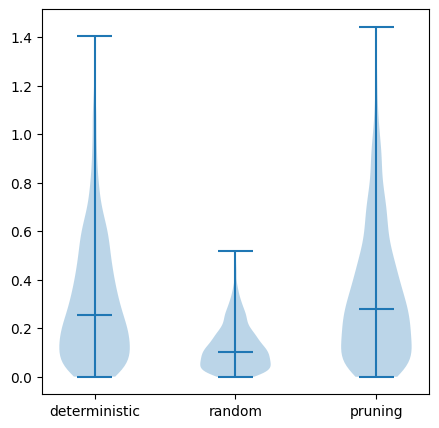

In [17]:
# make violin plot
import matplotlib.pyplot as plt
import seaborn as sns

data = [det_diff, random_diff, pruning_diff]
labels = ['deterministic', 'random', 'pruning']

fig = plt.figure(figsize =(5,5))
plt.violinplot(data, showmedians=True)
plt.xticks([1, 2, 3], labels)
plt.show()

In [18]:
# do the assumption test for different scenarios with n=100 simulations
n = 1000
number_states = 4
sequence_length = 5
p_effect = 0.7
p_state_change = 1/4

mean_0 = []
mean_1 = []

for i in range(n):
    
        gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, sequence_length, p_effect, p_state_change, mean=0)
        mean_0.append((gmean_sequence_effects, gmean_single_site_effects))
        
        gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, sequence_length, p_effect, p_state_change, mean=1)
        mean_1.append((gmean_sequence_effects, gmean_single_site_effects))

#get differences between gmean_sequence_effects and gmean_single_site_effects
mean_0_diff = [np.abs(mean_0[i][0] - mean_0[i][1]) for i in range(n)]
mean_1_diff = [np.abs(mean_1[i][0] - mean_1[i][1]) for i in range(n)]

frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [1.       0.05     1.98     ... 0.06993  2.769228 0.335664]
gmean sequence effects:  0.76765
product of gmean single site effects:  0.53014
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [1.        6.08      2.98      ... 6.1636608 3.0210048 1.01376  ]
gmean sequence effects:  2.42177
product of gmean single site effects:  8.35451
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [ 1.       0.59     4.78    ...  2.73642 22.16964  1.57692]
gmean sequence effects:  1.12698
product of gmean single site effects:  1.33228
gmean sequence effects i

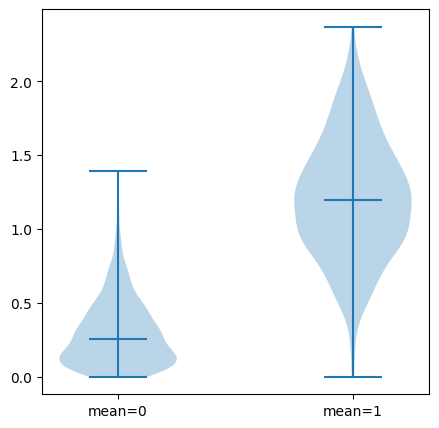

In [19]:
# make violin plot
data = [mean_0_diff, mean_1_diff]
fig = plt.figure(figsize =(5,5))
plt.violinplot(data, showmedians=True)
plt.xticks([1, 2], ['mean=0', 'mean=1'])
plt.show()

frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [1.         1.         0.9        ... 0.7939008  0.71451072 0.40488941]
gmean sequence effects:  1.04224
product of gmean single site effects:  1.1044
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [5.63135147e-02 6.25705719e-03 6.25705719e-03 ... 1.61505583e-11
 1.61505583e-11 1.61505583e-11]
sequence_effects:  [1.         0.77       1.         ... 0.16936537 0.21995502 0.21995502]
gmean sequence effects:  1.18995
product of gmean single site effects:  1.23207
gmean sequence effects is equal to product of gmean single site effects:  False
frequencies:  [2.37304688e-01 2.63671875e-02 2.63671875e-02 ... 4.01877572e-06
 4.01877572e-06 4.01877572e-06]
sequence_effects:  [1.       1.35     1.       ... 3.054915 2.2629   3.84693 ]
gmean sequence effects:  0.94983
product of gmean single site effects:  0.8838
gmean se

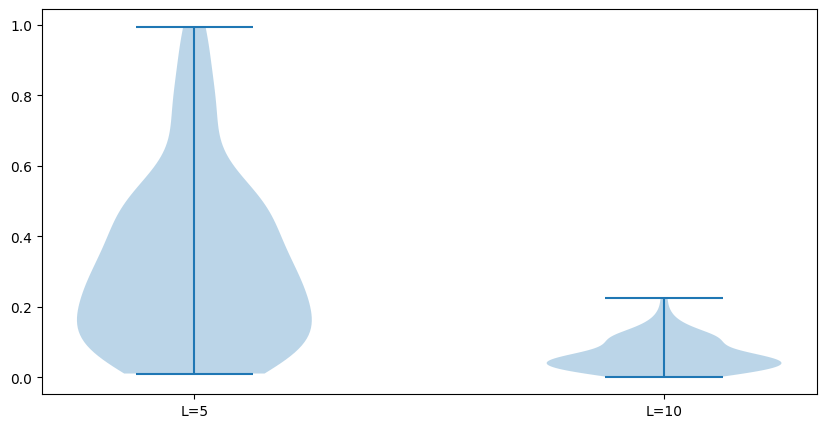

In [20]:
# do the assumption test for L = 5 and L = 10
n = 100
number_states = 4
sequence_length = 5
p_effect = 0.7
p_state_change = 1/4

L_5 = []
L_10 = []

for i in range(n):
        
            gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, 5, p_effect, p_state_change)
            L_5.append((gmean_sequence_effects, gmean_single_site_effects))
            
            gmean_sequence_effects, gmean_single_site_effects = assumption_test(number_states, 10, p_effect, p_state_change)
            L_10.append((gmean_sequence_effects, gmean_single_site_effects))

#get differences between gmean_sequence_effects and gmean_single_site_effects

L_5_diff = [np.abs(L_5[i][0] - L_5[i][1]) for i in range(n)]
L_10_diff = [np.abs(L_10[i][0] - L_10[i][1]) for i in range(n)]

# make violin plot
data = [L_5_diff, L_10_diff]
fig = plt.figure(figsize =(10, 5))
plt.violinplot(data)
plt.xticks([1, 2], ['L=5', 'L=10'])
plt.show()

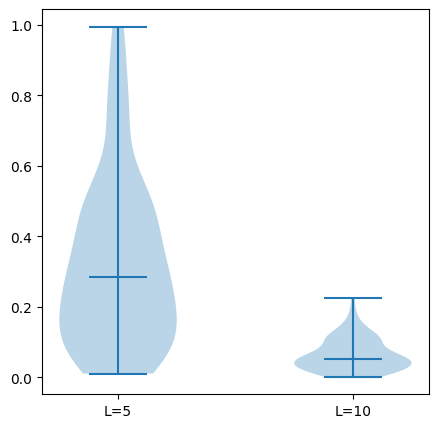

In [21]:
data = [L_5_diff, L_10_diff]
fig = plt.figure(figsize =(5,5))
plt.violinplot(data, showmedians=True)
plt.xticks([1, 2], ['L=5', 'L=10'])
plt.show()